In [1]:
import numpy as np
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import pandas as pd
import japanize_matplotlib
from jax.example_libraries import optimizers
from functools import partial

### 参考
- https://kazmus.hatenablog.jp/entry/2017/03/02/204925
- https://qiita.com/TbsYS/items/b1c03c6d3d470287bd6b

In [8]:
@partial(jax.jit, static_argnums=0)
def solve_byRK(f, dt, tn, xn, u, seed):
    # 4次ルンゲクッタ法
    k1 = f(tn, xn, u, seed)
    k2 = f(tn+dt/2., xn+k1*dt/2., 0, seed)
    k3 = f(tn+dt/2., xn+k2*dt/2., 0, seed)
    k4 = f(tn+dt, xn+k3*dt, 0, seed)
    xn1 = xn + dt*(k1 + 2*k2 + 2*k3 + k4)/6.
    
    return xn1

In [9]:
@jax.jit
def dyn(t, x, u, seed):
    tmp1 = -x[0] + x[1]*jnp.sin(x[1])
    tmp2 = -x[0]*jnp.sin(x[1]) + u
    tmp = jnp.array([tmp1, tmp2])
    rng = jax.random.PRNGKey(seed)
    tmp += jax.random.uniform(rng, [2,]) - 0.5
    return tmp

In [10]:
dt = 0.1
stop_time = 100
step_num = int(stop_time/dt) + 1 
ts = np.linspace(0, stop_time, step_num)
init_x = np.array([7., 9.])
seeds = np.random.randint(0, 255, step_num-1) #乱数固定

In [11]:
def get_unforced_response():
    xs = np.zeros((2,step_num))    
    xs[:,0] = init_x
    for k, t in enumerate(ts):    
        if k > 0:
            x = solve_byRK(dyn, dt, t, x, 0, seeds[k-1])
            xs[:, k] = x
        else:
            # 初期値
            x = jnp.array(init_x)
    return xs

In [53]:
xs = get_unforced_response()
df = pd.DataFrame()
df["Time"] = ts
df["x1"] = xs[0,:]
df["x2"] = xs[1,:]

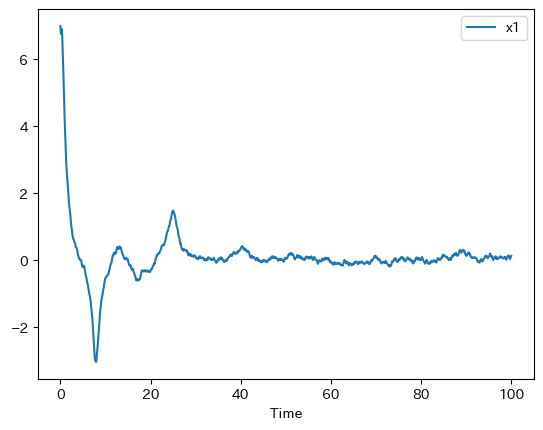

In [54]:
df.plot("Time", "x1");

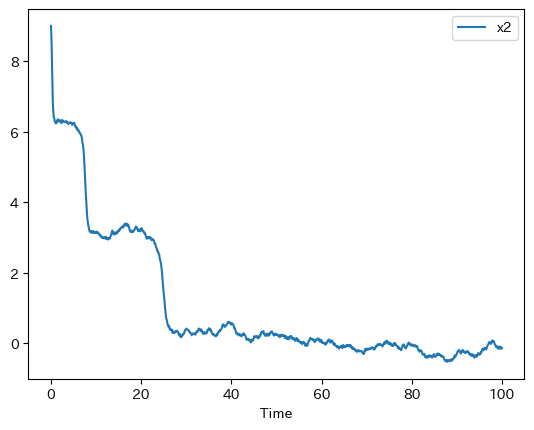

In [55]:
df.plot("Time", "x2");

In [34]:
@jax.jit
def get_ivent_trigger(x, x_hat, L0, L1, L2):
    tmp = jnp.concat([x, x_hat])
    return tmp @ L2 @ tmp.T + L1.T @ tmp.T + L0

In [56]:
def get_test_response():
    K = jnp.array([0.0196, -0.837])
    L0 = -1.6522
    L1 = jnp.array([ -0.218, -0.0347, -0.5838, -0.3667])
    L2 = jnp.array([[-0.0940, -0.2975, -0.8563, 0.3702],
                    [-0.2975, 0.8026, 0.2669, -0.1481],
                    [-0.8563, 0.2669, -0.7348, -0.0067],
                    [0.3702, -0.1481, -0.0067, -0.3706]])
    
    xs = np.zeros((2,step_num))
    trgs = np.zeros(step_num)
    xs[:,0] = init_x
    for k, t in enumerate(ts):    
        if k > 0:
            u = K @ x.T
            act_x = solve_byRK(dyn, dt, t, act_x, u, seeds[k-1])
            xs[:, k] = act_x
            iv_trg = get_ivent_trigger(act_x, x, L0, L1, L2)
            if iv_trg >= 0:
                x = jnp.copy(act_x)
                if k < step_num-1:
                    trgs[k+1] = 1
            
        else:
            # 初期値
            act_x = jnp.array(init_x)
            x = jnp.copy(act_x)
    return xs, trgs

In [57]:
xs, trgs = get_test_response()
df2 = pd.DataFrame()
df2["Time"] = ts
df2["x1"] = xs[0,:]
df2["x2"] = xs[1,:]

In [58]:
np.sum(trgs)

0.0

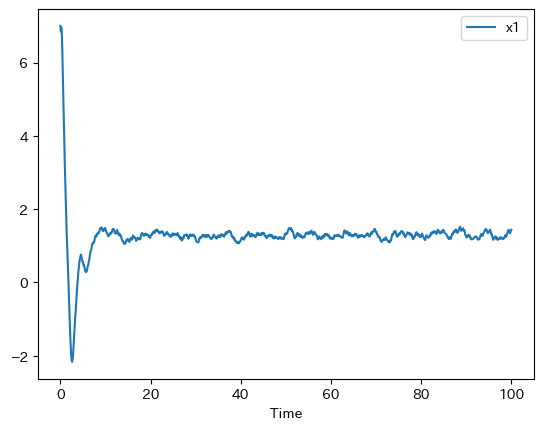

In [59]:
df2.plot("Time", "x1");

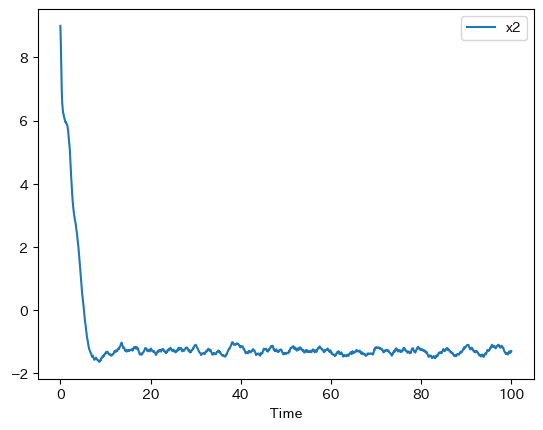

In [60]:
df2.plot("Time", "x2");

In [62]:
Q = jnp.diag(jnp.array([10,10,10,10]))
R = 1
lam = 0.1
@jax.jit
def loss(xs, us, trgs):
    J = 0
    for x in xs:
        J += x @ Q @ x.T
    for u in us:
        J += u * R * u.T
    J += lam * jnp.sum(trgs)
    return J